## 3.1 Tiling Calculations

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# scaling constants
B = 8
KB = 1024
MB = KB * 1024
GB = MB * 1024


In [2]:
"""_summary_
R = filter height
S = filter width
C = input channels
M = filter (output) channels
P = output feature map height
Q = output feature map width
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def get_tiling_comparison(R, S, C, M, P, Q, L, T):
    cache_miss_wo_tiling = ((C*R*S)/L) * (P*Q*M) + C*R*S*P*Q*M + ((P*Q*M)/L)

    cache_miss_w_tiling = (2*C*R*S*P*Q*M)/(L*T) + (P*Q*M)/L

    print(f"cache misses without tiling: {round(cache_miss_wo_tiling, 3)}")
    print(f"cache misses with tiling: {round(cache_miss_w_tiling, 3)}")

    factor = round(cache_miss_wo_tiling / cache_miss_w_tiling, 3)
    print(f"factor: {factor}")
    
    # * multiply T by 4 for fp32, 1 for uint8
    mem_use = round((3 * ((T*4)**2)) / KB, 3)
    print(f"mem use: {mem_use}KB")
    
    # horizontal/vertical tile loads weights
    # h_tiles_w = (C*R*S) / T
    # v_tiles_w = M / T
    
    # # horizontal/vertical tile loads input feature maps
    # h_tiles_if = (P*Q) / T
    # v_tiles_if = (C*R*S) / T
    
    # # horizontal/vertical tile loads output feature maps
    # h_tiles_of = (P*Q) / T
    # v_tiles_of = M / T

    # tile_loads = round(h_tiles_w * v_tiles_w + h_tiles_if * v_tiles_if + h_tiles_of * v_tiles_of, 3)
    # print(f"min tile loads: {tile_loads}")

# Conv 1
print("Conv 1 L1D")
get_tiling_comparison(5, 5, 3, 32, 60, 60, 16, 32)
print()

print("Conv 1 L1D, L2")
get_tiling_comparison(5, 5, 3, 32, 60, 60, 16, 165)
print()

print("Conv 1 L1D, L2, L3")
get_tiling_comparison(5, 5, 3, 32, 60, 60, 16, 923)
print()


# Conv 2
print("Conv 2 L1D")
get_tiling_comparison(5, 5, 32, 32, 56, 56, 16, 32)
print()

print("Conv 2 L1D, L2")
get_tiling_comparison(5, 5, 32, 32, 56, 56, 16, 165)
print()

print("Conv 2 L1D, L2, L3")
get_tiling_comparison(5, 5, 32, 32, 56, 56, 16, 923)
print()


Conv 1 L1D
cache misses without tiling: 9187200.0
cache misses with tiling: 40950.0
factor: 224.352
mem use: 48.0KB

Conv 1 L1D, L2
cache misses without tiling: 9187200.0
cache misses with tiling: 13745.455
factor: 668.381
mem use: 1276.172KB

Conv 1 L1D, L2, L3
cache misses without tiling: 9187200.0
cache misses with tiling: 8370.098
factor: 1097.622
mem use: 39934.172KB

Conv 2 L1D
cache misses without tiling: 85305472.0
cache misses with tiling: 319872.0
factor: 266.686
mem use: 48.0KB

Conv 2 L1D, L2
cache misses without tiling: 85305472.0
cache misses with tiling: 67091.394
factor: 1271.482
mem use: 1276.172KB

Conv 2 L1D, L2, L3
cache misses without tiling: 85305472.0
cache misses with tiling: 17144.373
factor: 4975.713
mem use: 39934.172KB



## Convolutional Memory Access Patterns

Conv 2 Optimized


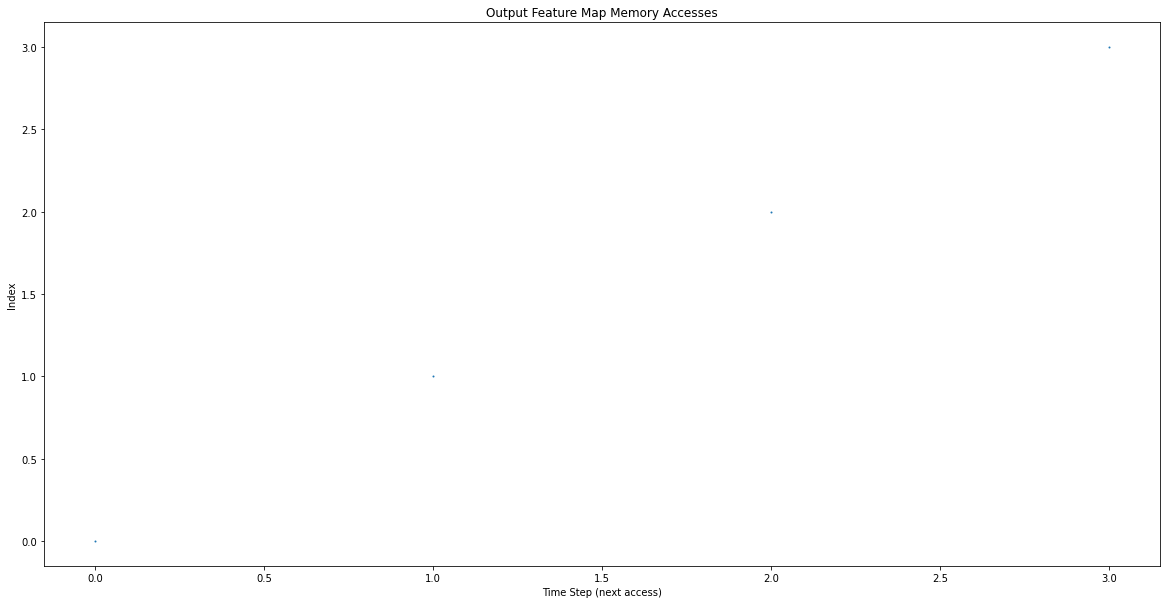

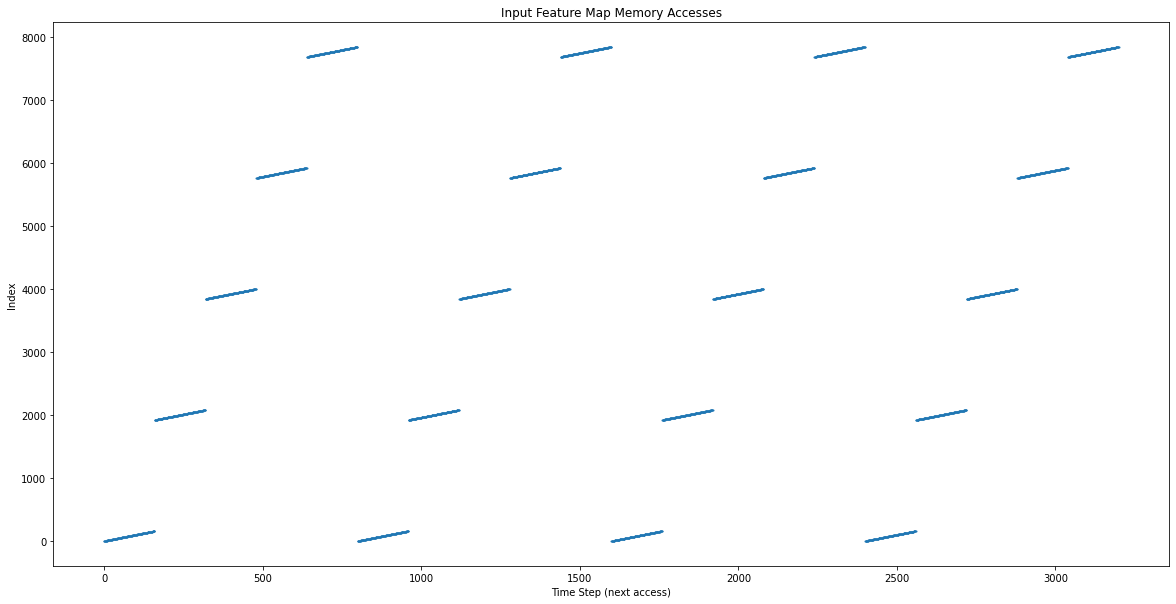

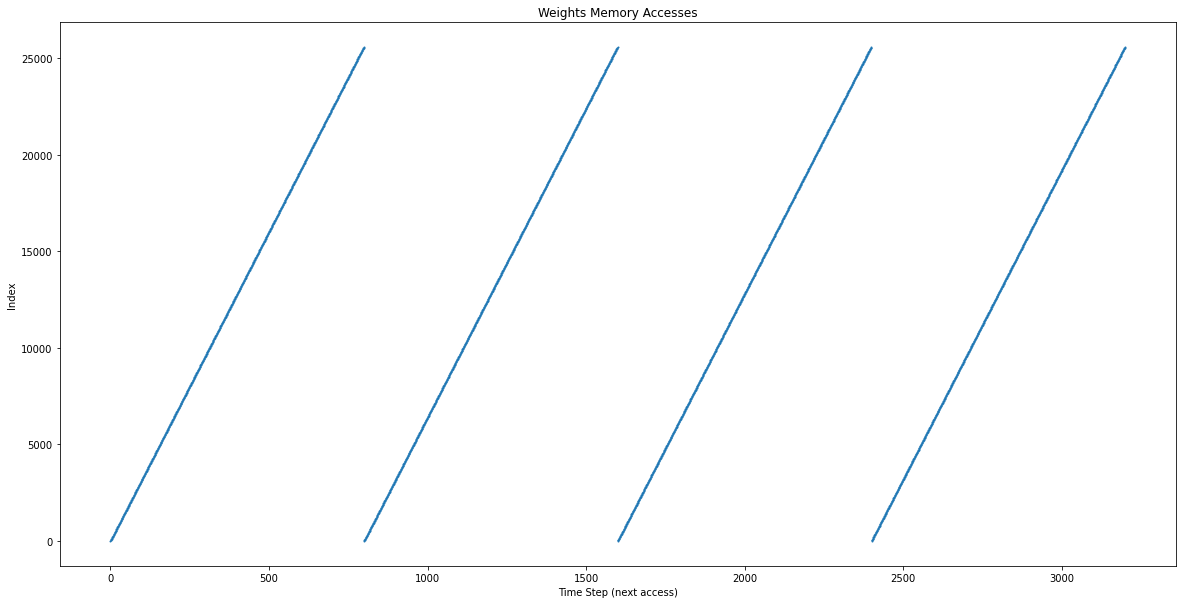

In [3]:
# Convolutional Layer Memory Access Patterns
# y axis will have index of array access
# x axis will have Time Step (next access)

BREAK_OF_MAP_ROW = 1
BREAK_OF_MAP_COL = 1
BREAK_FILTER_CHAN = 4

"""_summary_
Shows the original memory access patterns for convolution
R = filter height
S = filter width
C = input channels
M = filter (output) channels
H = input feature map height
W = input feature map width
P = output feature map height
Q = output feature map width
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def show_mem_accesses_conv_orig(R, S, C, M, H, W, P, Q, L, T):
    of_map_accesses = []
    if_map_accesses = []
    w_accesses = []
    for filter_chan in range(M):
        if filter_chan == BREAK_FILTER_CHAN:
            break
        for of_map_row in range(P):
            if of_map_row == BREAK_OF_MAP_ROW:
                break
            for of_map_col in range(Q):
                if of_map_col == BREAK_OF_MAP_COL:
                    break
                of_map_accesses.append(of_map_row*Q*M + of_map_col*M + filter_chan)
                if_map_row_limit = of_map_row + R
                if_map_col_limit = of_map_col + S
                for row_idx in range(of_map_row, if_map_row_limit):
                    for col_idx in range(of_map_col, if_map_col_limit):
                        for chan_idx in range(C):
                            if_map_accesses.append(row_idx*W*C + col_idx*C + chan_idx)
                            w_accesses.append((row_idx-of_map_row)*S*C*M + (col_idx-of_map_col)*C*M + chan_idx*M + filter_chan)
    
    # create 3 separate dot plots
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(of_map_accesses)), of_map_accesses, s=1)
    plt.title("Output Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(if_map_accesses)), if_map_accesses, s=1)
    plt.title("Input Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(w_accesses)), w_accesses, s=1)
    plt.title("Weights Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    # print("OF MAP ACCESSES: ", of_map_accesses)
    # print("IF MAP ACCESSES: ", if_map_accesses)
    # print("WEIGHT ACCESSES: ", w_accesses)
    # print()


"""_summary_
Shows the optmized memory access patterns for convolution
R = filter height
S = filter width
C = input channels
M = filter (output) channels
H = input feature map height
W = input feature map width
P = output feature map height
Q = output feature map width
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def show_mem_accesses_conv_optim(R, S, C, M, H, W, P, Q, L, T):
    of_map_accesses = []
    if_map_accesses = []
    w_accesses = []
    for of_map_row in range(P):
        if of_map_row == BREAK_OF_MAP_ROW:
            break
        for of_map_col in range(Q):
            if of_map_col == BREAK_OF_MAP_COL:
                break
            for filter_chan in range(M):
                if filter_chan == BREAK_FILTER_CHAN:
                    break
                of_map_accesses.append(of_map_row*Q*M + of_map_col*M + filter_chan)
                if_map_row_limit = of_map_row + R
                if_map_col_limit = of_map_col + S
                for row_idx in range(of_map_row, if_map_row_limit):
                    for col_idx in range(of_map_col, if_map_col_limit):
                        for chan_idx in range(C):
                            if_map_accesses.append(row_idx*W*C + col_idx*C + chan_idx)
                            w_accesses.append((row_idx-of_map_row)*S*C*M + (col_idx-of_map_col)*C*M + chan_idx*M + filter_chan)
    
    # create 3 separate dot plots
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(of_map_accesses)), of_map_accesses, s=1)
    plt.title("Output Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(if_map_accesses)), if_map_accesses, s=1)
    plt.title("Input Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(w_accesses)), w_accesses, s=1)
    plt.title("Weights Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    # print("OF MAP ACCESSES: ", of_map_accesses)
    # print("IF MAP ACCESSES: ", if_map_accesses)
    # print("WEIGHT ACCESSES: ", w_accesses)
    # print()


# print("Conv 1 Original")
# show_mem_accesses_conv_orig(5, 5, 3, 32, 64, 64, 60, 60, 16, 25)
# print("Conv 1 Optimized")
# show_mem_accesses_conv_optim(5, 5, 3, 32, 64, 64, 60, 60, 16, 25)

# print("Conv 2 Original")
# show_mem_accesses_conv_orig(5, 5, 32, 32, 60, 60, 56, 56, 16, 25)
print("Conv 2 Optimized")
show_mem_accesses_conv_optim(5, 5, 32, 32, 60, 60, 56, 56, 16, 25)


## Max Pool Memory Access Patterns

Max Pool 1 Optimized


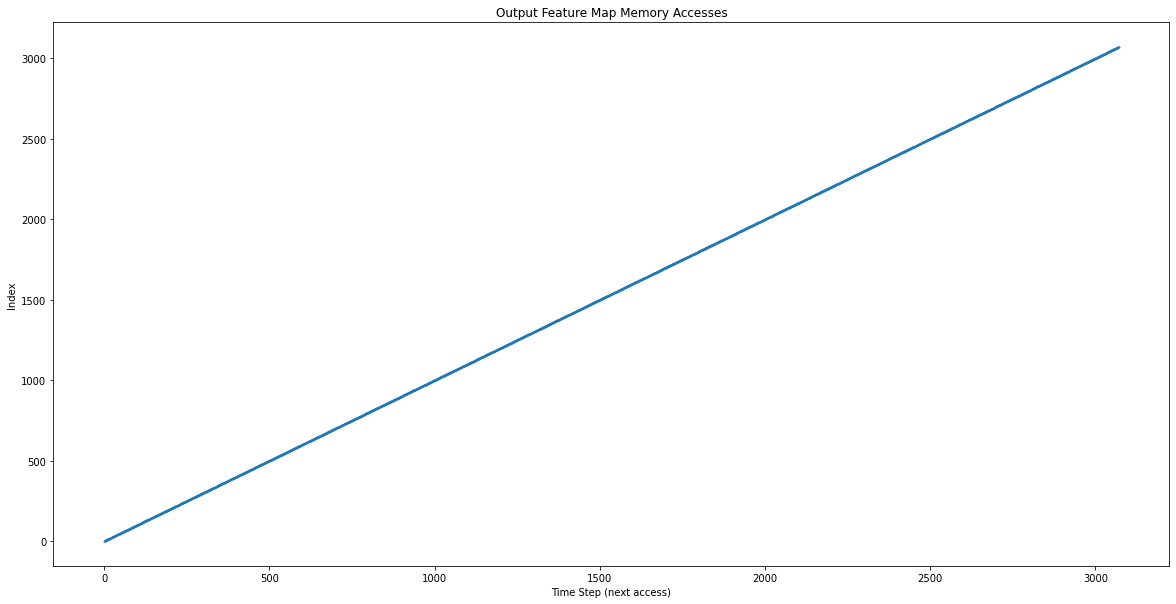

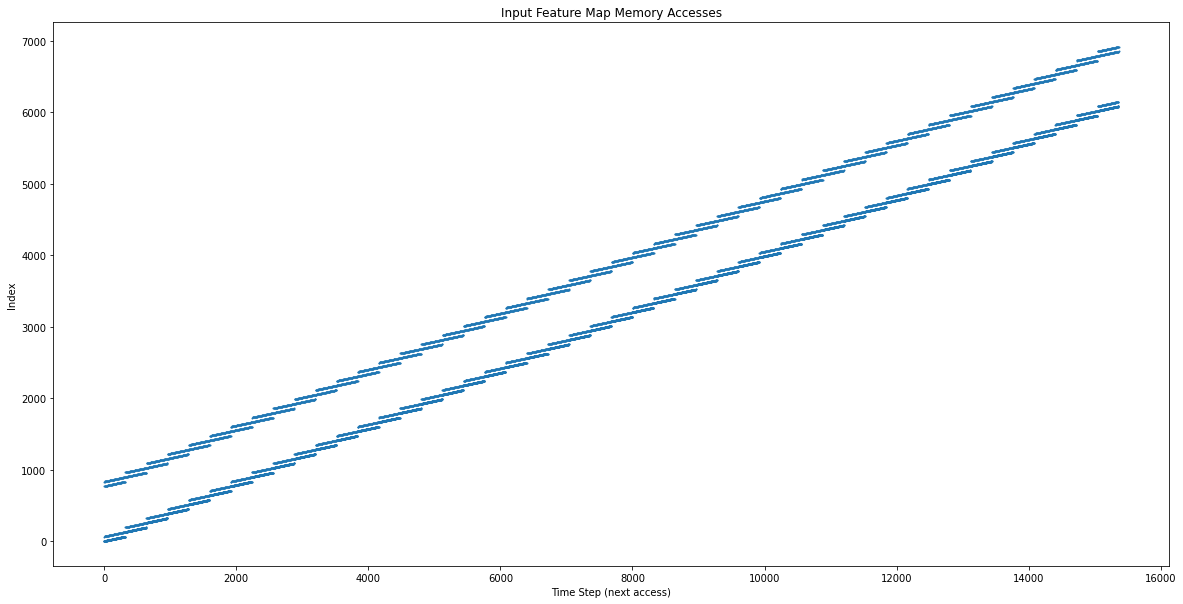

OF MAP ACCESSES:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2

In [4]:
# Max Pool Layer Memory Access Patterns
# y axis will have index of array access
# x axis will have Time Step (next access)

BREAK_OF_MAP_ROW = 4
BREAK_OF_MAP_COL = 10000
BREAK_OF_MAP_CHAN = 10000

"""_summary_
Shows the original memory access patterns for max pooling
P = output feature map height
Q = output feature map width
M = output feature map channels
POOL_SIZE = max pool size
POOL_STRIDE = max pool stride
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def show_mem_accesses_max_pool_orig(P, Q, M, POOL_SIZE, POOL_STRIDE, L, T):
    of_map_accesses = []
    if_map_accesses = []
    for of_map_chan in range(M):
        if of_map_chan == BREAK_OF_MAP_CHAN:
            break
        for of_map_row in range(P):
            if of_map_row == BREAK_OF_MAP_ROW:
                break
            for of_map_col in range(Q):
                if of_map_col == BREAK_OF_MAP_COL:
                    break
                of_map_accesses.append(of_map_row*Q*M + of_map_col*M + of_map_chan)
                
                # calculate input feature map accesses
                cur_row = of_map_row * POOL_STRIDE
                cur_col = of_map_col * POOL_STRIDE
                if_map_accesses.append(cur_row*Q*M + cur_col*M + of_map_chan)
                if_map_row_limit = cur_row + POOL_SIZE
                if_map_col_limit = cur_col + POOL_SIZE
                for row_idx in range(cur_row, if_map_row_limit):
                    for col_idx in range(cur_col, if_map_col_limit):
                        if_map_accesses.append(row_idx*Q*M + col_idx*M + of_map_chan)
    
    # create 2 separate dot plots
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(of_map_accesses)), of_map_accesses, s=1)
    plt.title("Output Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(if_map_accesses)), if_map_accesses, s=1)
    plt.title("Input Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    print("OF MAP ACCESSES: ", of_map_accesses)
    print("IF MAP ACCESSES: ", if_map_accesses)


"""_summary_
Shows the optimized memory access patterns for max pooling
P = output feature map height
Q = output feature map width
M = output feature map channels
POOL_SIZE = max pool size
POOL_STRIDE = max pool stride
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def show_mem_accesses_max_pool_optim(P, Q, M, POOL_SIZE, POOL_STRIDE, L, T):
    of_map_accesses = []
    if_map_accesses = []
    for of_map_row in range(P):
        if of_map_row == BREAK_OF_MAP_ROW:
            break
        for of_map_col in range(Q):
            if of_map_col == BREAK_OF_MAP_COL:
                break
            for of_map_chan in range(M):
                if of_map_chan == BREAK_OF_MAP_CHAN:
                    break
                of_map_accesses.append(of_map_row*Q*M + of_map_col*M + of_map_chan)
                
                # calculate input feature map accesses
                cur_row = of_map_row * POOL_STRIDE
                cur_col = of_map_col * POOL_STRIDE
                if_map_accesses.append(cur_row*Q*M + cur_col*M + of_map_chan)
                if_map_row_limit = cur_row + POOL_SIZE
                if_map_col_limit = cur_col + POOL_SIZE
                for row_idx in range(cur_row, if_map_row_limit):
                    for col_idx in range(cur_col, if_map_col_limit):
                        if_map_accesses.append(row_idx*Q*M + col_idx*M + of_map_chan)
    
    # create 2 separate dot plots
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(of_map_accesses)), of_map_accesses, s=1)
    plt.title("Output Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(if_map_accesses)), if_map_accesses, s=1)
    plt.title("Input Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    print("OF MAP ACCESSES: ", of_map_accesses)
    print("IF MAP ACCESSES: ", if_map_accesses)


# print("Max Pool 1 Original")
# show_mem_accesses_max_pool_orig(12, 12, 64, 2, 2, 16, 25)
print("Max Pool 1 Optimized")
show_mem_accesses_max_pool_optim(12, 12, 64, 2, 2, 16, 25)


## Fully Connected (Dense) Memory Access Patterns

Dense 1 Original (already optimal)


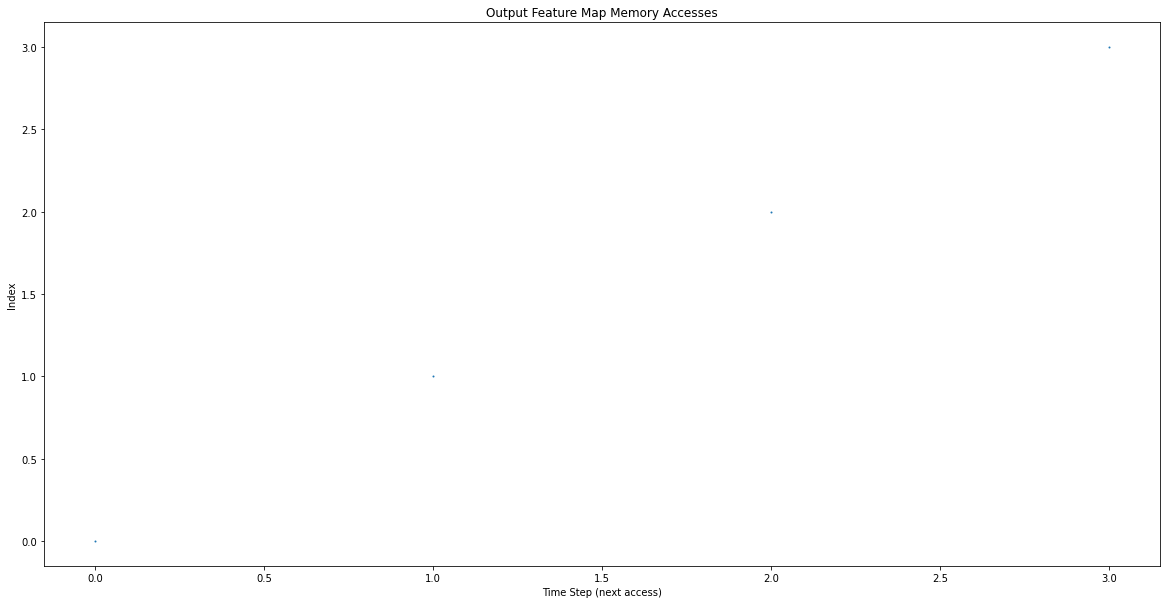

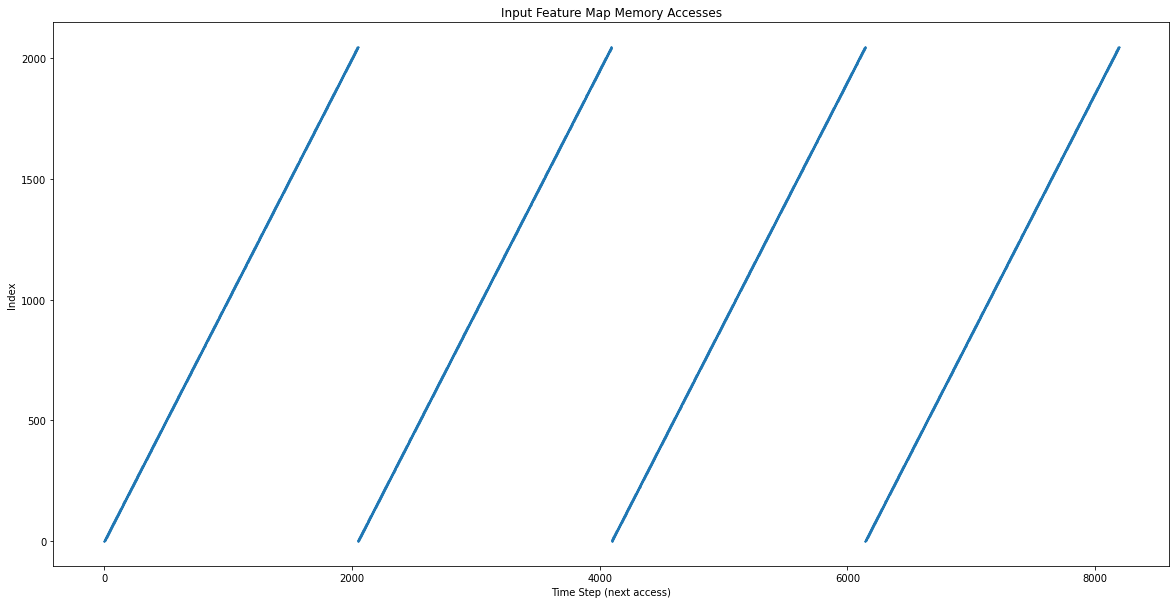

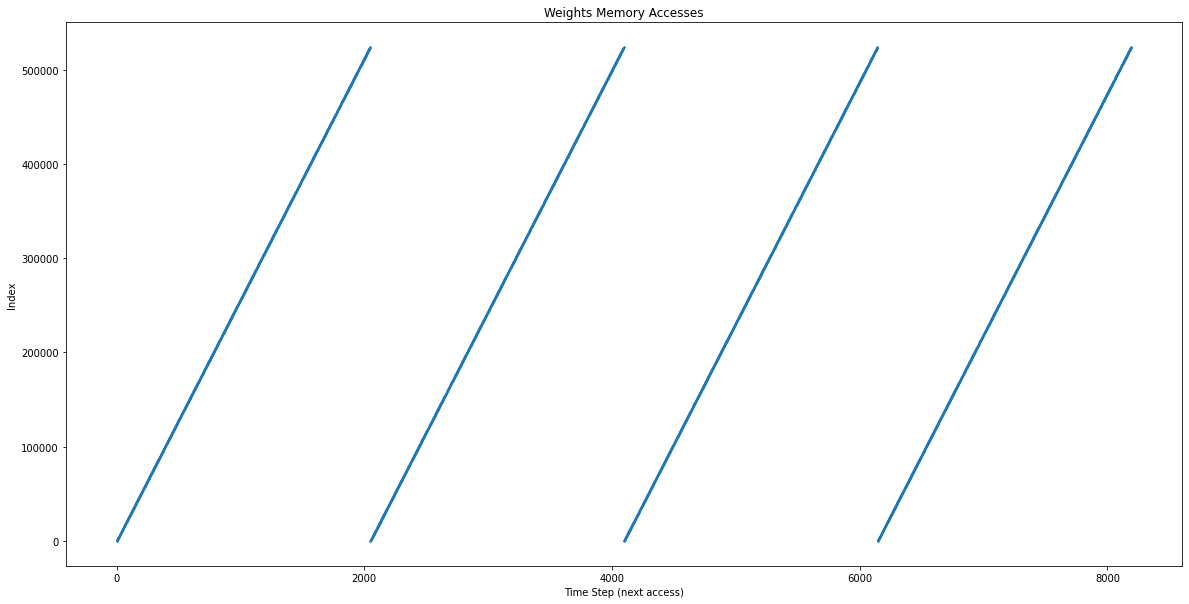

OF MAP ACCESSES:  [0, 1, 2, 3]
IF MAP ACCESSES:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 

In [5]:
# Fully Connected (Dense) Layer Memory Access Patterns
# y axis will have index of array access
# x axis will have Time Step (next access)

BREAK_OUT_IDX = 4
BREAK_IN_IDX = 10000

"""_summary_
Shows the original memory access patterns for dense layer
IN_LEN = input feature map length
OUT_LEN = output feature map length
L = cache line size (4B for fp32, 1B for uint8)
T = tile size (4B for fp32, 1B for uint8)
"""
def show_mem_accesses_dense_orig(IN_LEN, OUT_LEN, L, T):
    of_map_accesses = []
    if_map_accesses = []
    w_accesses = []
    for out_idx in range(OUT_LEN):
        if out_idx == BREAK_OUT_IDX:
            break
        for in_idx in range(IN_LEN):
            if in_idx == BREAK_IN_IDX:
                break
            if_map_accesses.append(in_idx)
            w_accesses.append(in_idx*OUT_LEN + out_idx)
        of_map_accesses.append(out_idx)
    
    # create 3 separate dot plots
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(of_map_accesses)), of_map_accesses, s=1)
    plt.title("Output Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(if_map_accesses)), if_map_accesses, s=1)
    plt.title("Input Feature Map Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(range(len(w_accesses)), w_accesses, s=1)
    plt.title("Weights Memory Accesses")
    plt.xlabel("Time Step (next access)")
    plt.ylabel("Index")
    plt.show()
    print("OF MAP ACCESSES: ", of_map_accesses)
    print("IF MAP ACCESSES: ", if_map_accesses)
    print("WEIGHT ACCESSES: ", w_accesses)


print("Dense 1 Original (already optimal)")
show_mem_accesses_dense_orig(2048, 256, 16, 25)
